#### Objective: Develop a random forest model to classify the land cover of a remote sensing image 

##### Step 1: Import necessary packages

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

##### Step 2: Use the rasterio package to load the data

In [2]:
# Load la_eagleview_small.tif
land_image = rasterio.open('data/4_randomForest/la_eagleview_small.tif')

print("la_eagleview_small.tif Height:", land_image.height)
print("la_eagleview_small.tif Width:", land_image.width)
print("la_eagleview_small.tif Band Count:", land_image.count)

la_eagleview_small.tif Height: 1444
la_eagleview_small.tif Width: 2122
la_eagleview_small.tif Band Count: 3


##### Step 3: Plot the data

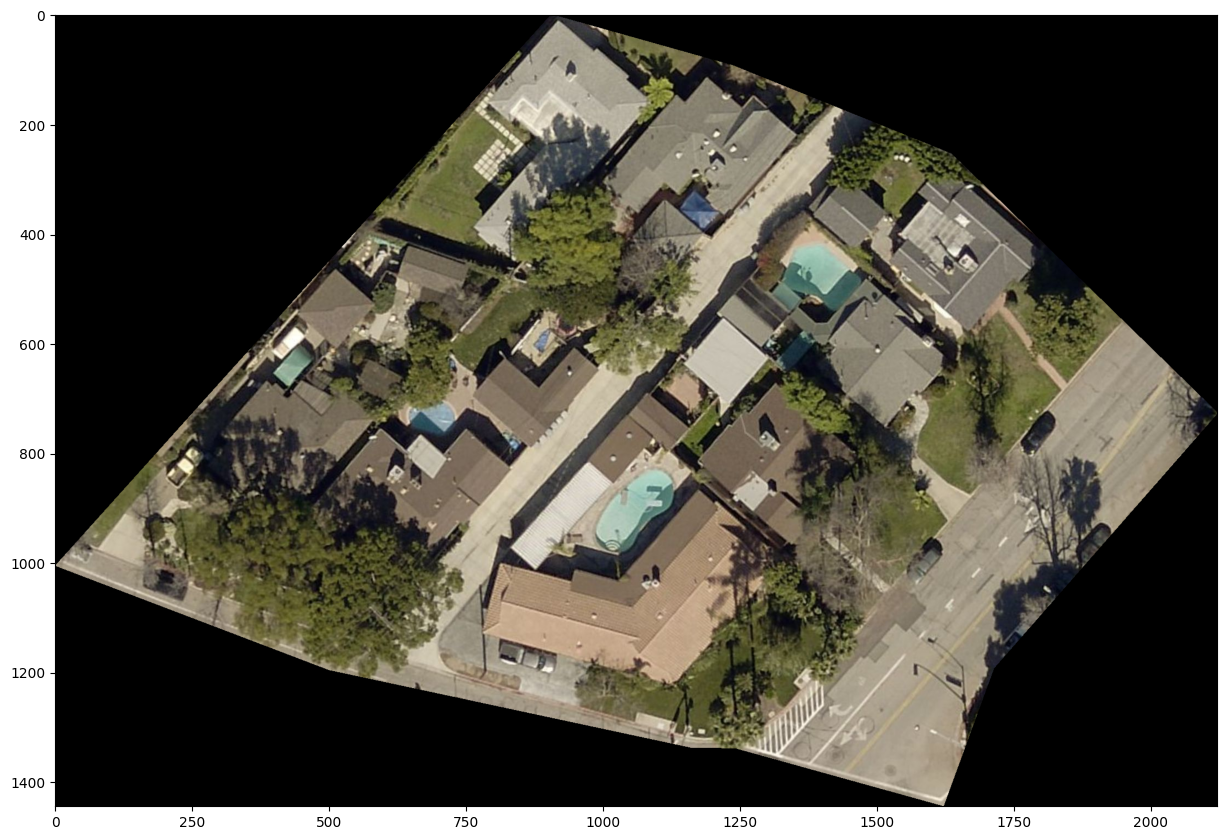

In [3]:
plt.figure(figsize = (15,15))
# show the aerial image
blue = land_image.read(3, masked=True)
green = land_image.read(2, masked=True)
red = land_image.read(1, masked=True)
rgb_land = np.dstack((red, green, blue))
plt.imshow(rgb_land)
plt.show()

In [4]:
# Load training_data_ev.tif
land_label = rasterio.open('data/4_randomForest/training_data_ev.tif')
print("training_data_ev.tif Height:", land_label.height)
print("training_data_ev.tif Width:", land_label.width)
print("training_data_ev.tif Band Count:", land_label.count)

training_data_ev.tif Height: 1444
training_data_ev.tif Width: 2122
training_data_ev.tif Band Count: 1


##### Step 4: Load the reference ground truth and visualize it

###### The values in our training data “Training_data_ev.tif” are 0,1,2,3,4,5,6.  
{'pool': 1, 'street': 2, 'grass': 3, 'roof': 4, 'tree': 5, 'shadow': 6, ‘no data’:0}. 
To know how the training data looks like, we may want to overlay these two images.

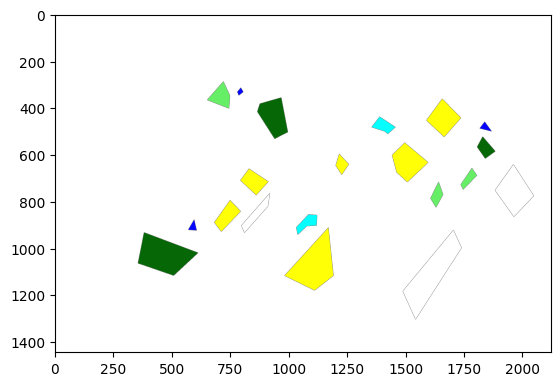

In [5]:
# create a color palette to color the labels. This is because we may want to use some intuitive 
# colors to show the label (e.g., blue for pool) 
palette = np.array([[0, 0, 0, 0], # no data
     [0, 255, 255,250], # pool
     [255, 255, 255,250], # street
     [100,238,100,250], #grass
     [255, 255, 0,250], #roof
     [0,100,0,250], #tree
     [0, 0, 255,250] #shadow
     ])
land_label_data = land_label.read(1)
plt.imshow(palette[land_label_data]) 

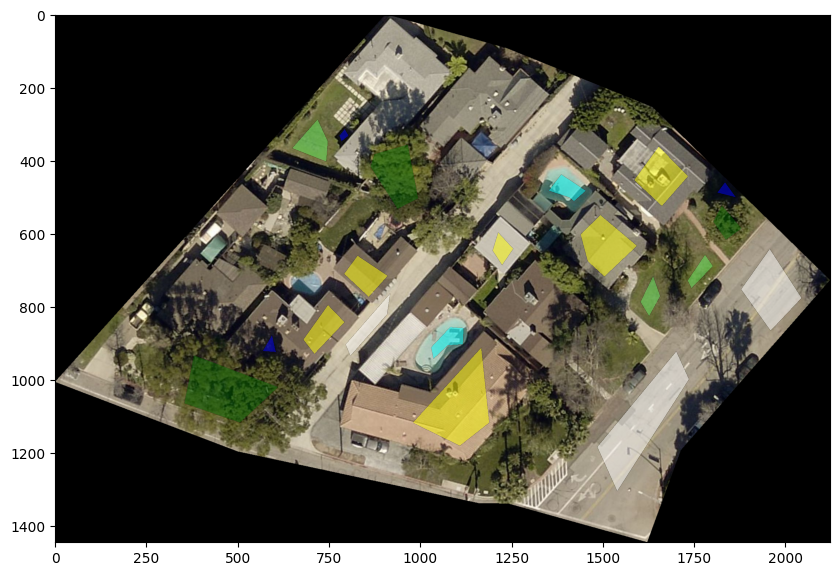

In [6]:
# Show the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_land)

# Show the label data on top of the image
plt.imshow(palette[land_label_data], alpha=0.5)
# Display the plot
plt.show()

# Close the datasets
land_image.close()
land_label.close()
 

##### Step 5: Now to prep our training data

In [7]:
# Get the labeled training data for each band
red_train = red[land_label_data>0]
blue_train = blue[land_label_data>0]
green_train = green[land_label_data>0]
X_label = np.column_stack((red_train, blue_train,green_train)) # put the three features as three columns of the matrix

# Get the labeled value
y_label = land_label_data[land_label_data>0]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.2, random_state=42)

##### Step 6: Build a base random forest model, with the min_samples_leaf parameter as 10. 
Train the model using the training data.

In [9]:
# Initialize the Random Forest model with min_samples_leaf set to 10
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, random_state=42)

# Train the model
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=10, random_state=42)

##### Step 7: Make predictions using the trained model on the test data, and evaluate the result
Two evaluation metrics often used are: accuracy and confusion matrix.

In [10]:
# Predict on the test data
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9553594467667854
Confusion Matrix:
[[ 1524     0     0     1     0     0]
 [    0 11057     0   355    10     0]
 [    0     0  1929     1   364     0]
 [    0   244     0 13835    56     0]
 [    0    12   609    61  8234    10]
 [    0     0     0     4     3   445]]


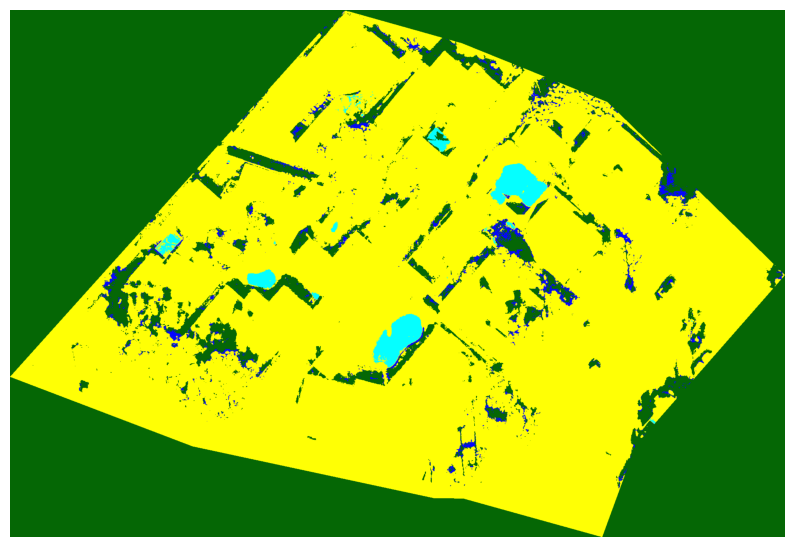

In [11]:
# First, we need to reshape rgb_land to a 2D array for prediction
# Each pixel is a row and the three bands are the columns
flat_pixels = rgb_land.reshape(-1, 3)

# Use the trained model to predict classes for each pixel
predicted_labels = rf.predict(flat_pixels)

predicted_colors = palette[predicted_labels].astype(np.uint8)

# Reshape the 1D array of predicted labels back into a 2D image
classified_image = predicted_colors.reshape(rgb_land.shape[0], rgb_land.shape[1], 4)

# Now we visualize the predicted_labels_image
plt.figure(figsize=(10, 10))
plt.imshow(classified_image)
plt.axis('off')  # Hide the axes ticks and labels
plt.show()

In [12]:
# Prepare all the pixels of this image
# X_whole = np.column_stack((red.ravel(), green.ravel(), blue.ravel()))
X_whole = np.column_stack(( green.ravel(), blue.ravel(),red.ravel()))

# Predict with the trained model
y_whole_pred = rf.predict(X_whole)

# Reshape the prediction result into the shape of the image
y_whole_pred_reshape = y_whole_pred.reshape(land_image.height, land_image.width)

# Map the predicted classes to colors for visualization
predicted_image = palette[y_whole_pred_reshape]

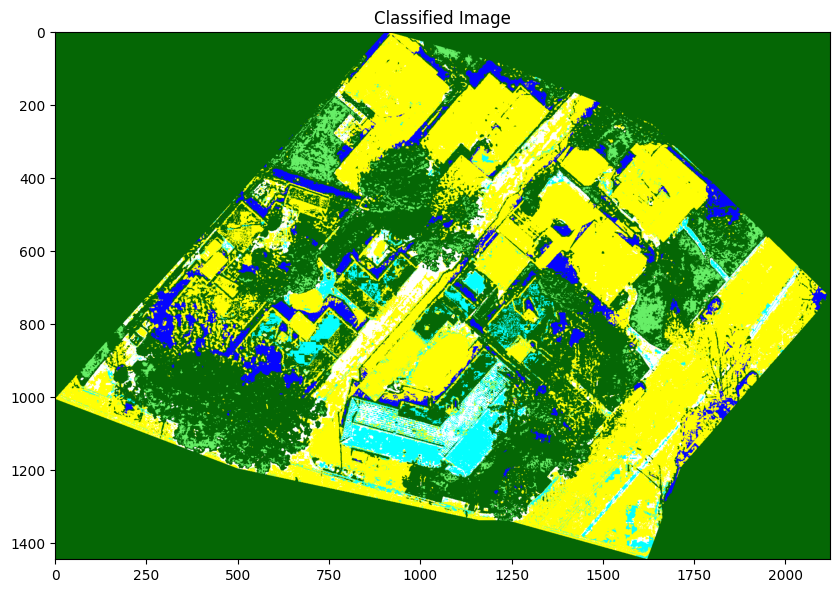

In [13]:
# Show the classified image
plt.figure(figsize=(10, 10))
plt.imshow(predicted_image)
plt.title("Classified Image")
plt.show()